In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from src.Calculators.ray_cesare import ray_maker
from src.Luminosity.special_radii import get_thermr, get_photosphere, calc_photosphere
from astropy.coordinates import cartesian_to_spherical
from src.Calculators.legion_of_casters import THROUPLE_S_CASTERS
import healpy as hp
Msol_to_g = 1.989e33 # [g]
Rsol_to_cm = 6.957e10 # [cm]
den_converter = Msol_to_g / Rsol_to_cm**3
X = 0.74
Z = 0.02
m = 6
Rt = (10**m)**(1/3)
# fix = 844

In [2]:
# def kramers(temp, rho):
#     kr = 1.2e26 * Z * (1+X) * rho * temp**(-7/2)
#     return kr

def scattering():
    kes = 0.2 * (1+X)
    return kes

def kramers_bound_free(temp, rho):
    krb = 1.2e26 * Z * (1+X) * rho * temp**(-7/2)
    return krb

def kramers_free_free(temp, rho):
    krf = 3.68 * 1e22 * (1-Z) * (1+X) * rho * temp**(-7/2)
    return krf

def kappa_ross_approx(temp, rho):
    """"Matsumoto approximation for Rosseland mean opacity"""
    km = 0.1 * Z
    kh = 1.1e-25 * Z**(0.5) * rho**0.5 * temp**(7.7)
    kk = kramers_bound_free(temp, rho)
    kes = scattering()
    kappa = km + kes + 1/(1/kh + 1/kk)
    return kappa

In [3]:
temp_table_ln = np.loadtxt('src/Opacity/T.txt')
temp_table = np.exp(temp_table_ln)
den_table_ln = np.loadtxt('src/Opacity/rho.txt')
den_table = np.exp(den_table_ln)
ross_table_ln = np.loadtxt('src/Opacity/ross.txt')
ross_table = np.exp(ross_table_ln)
planck_table_ln = np.loadtxt('src/Opacity/planck.txt')
planck_table = np.exp(planck_table_ln)
scatter_table_ln = np.loadtxt('src/Opacity/scatter.txt')
scatter_table = np.exp(scatter_table_ln)

In [4]:
index_array = [0,50,100,120]
rho_test = np.zeros(len(index_array)) #[1e-13, 1e-9, 1e-7, 1e-3] 
# colors = ['orange', 'green', 'b', 'violet']
for i, index in enumerate(index_array):
    rho_test[i] = den_table[index]

In [5]:
""" Compute theorically K_R according to Matsumoto approximation"""
kappa_matsu = [] #every line correspond to one density's value
for i in range(len(rho_test)):
    singlerho_ross = np.zeros(len(temp_table))
    for j in range(len(temp_table)):
        singlerho_ross[j] = kappa_ross_approx(temp_table[j], rho_test[i])
    kappa_matsu.append(singlerho_ross)

In [6]:
""" Compute K_R according to Kramers' approximation """
kappa_kramer_boundfree = []
for i in range(len(rho_test)):
    singlerho_kram_boundfree = np.zeros(len(temp_table))
    for j in range(len(temp_table)):
        singlerho_kram_boundfree[j] = kramers_bound_free(temp_table[j], rho_test[i])
    kappa_kramer_boundfree.append(singlerho_kram_boundfree)

kappa_kramer_freefree = []
for i in range(len(rho_test)):
    singlerho_kram_freefree = np.zeros(len(temp_table))
    for j in range(len(temp_table)):
        singlerho_kram_freefree[j] = kramers_free_free(temp_table[j], rho_test[i])
    kappa_kramer_freefree.append(singlerho_kram_freefree)

In [7]:
""" Compute K_R according to scattering """
theory_scattering = []
for i in range(len(rho_test)):
    singlerho_scatter = np.zeros(len(temp_table))
    for j in range(len(temp_table)):
        singlerho_scatter[j] = scattering()
    theory_scattering.append(singlerho_scatter)

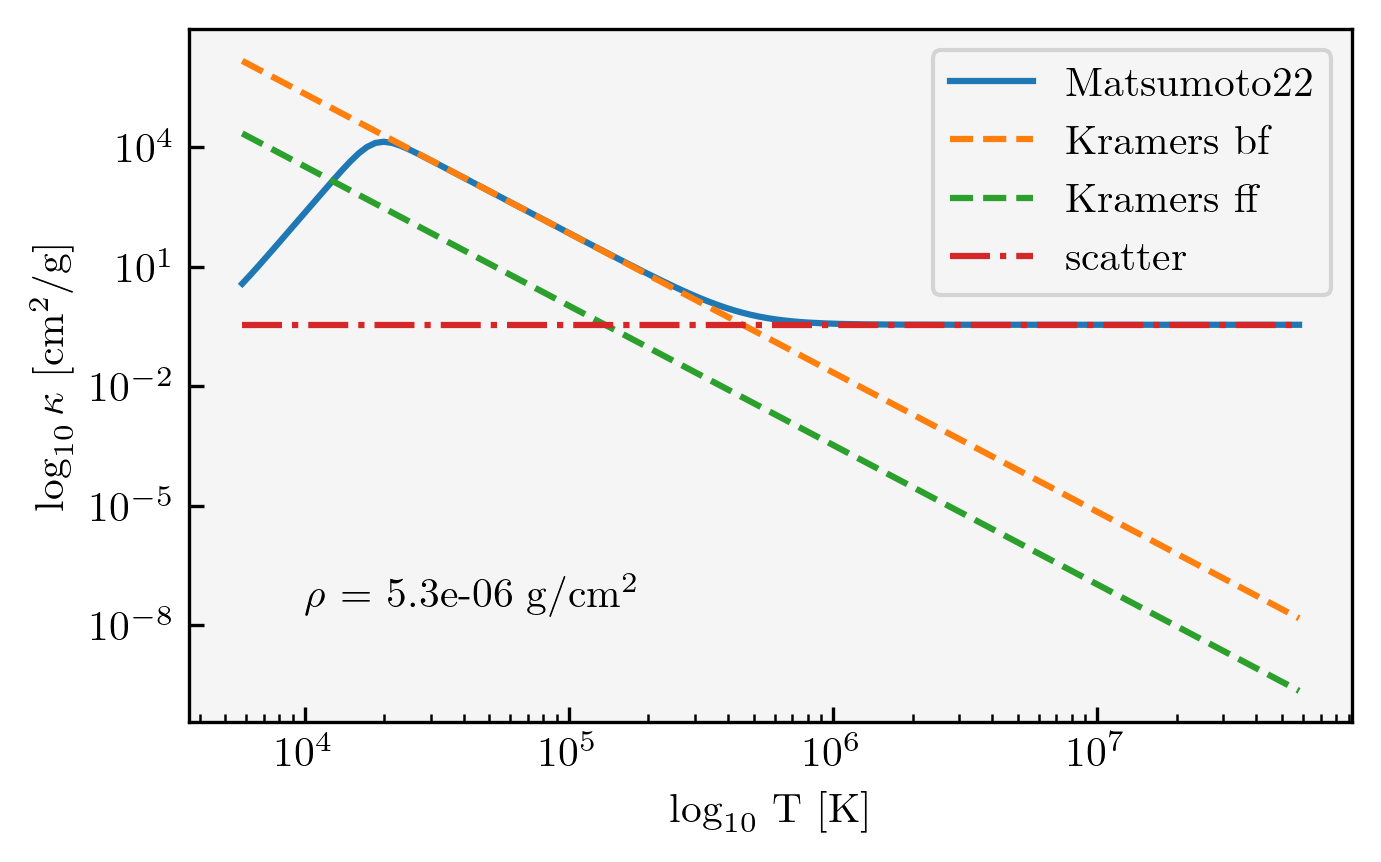

In [8]:
idx = 1
plt.plot(temp_table,kappa_matsu[idx], label = 'Matsumoto22')
plt.plot(temp_table,kappa_kramer_boundfree[idx], linestyle = 'dashed', label = 'Kramers bf')
plt.plot(temp_table,kappa_kramer_freefree[idx], linestyle = 'dashed', label = 'Kramers ff')
plt.plot(temp_table,theory_scattering[idx],  '-.', label = 'scatter')
plt.text(1e4, 3e-8, r'$\rho$ = %.1e g/cm$^2$' %rho_test[idx])
plt.xlabel(r'$\log_{10}$ T [K]')
plt.ylabel(r'$\log_{10} \kappa$ [cm$^2$/g]')
plt.loglog()
plt.legend()
plt.savefig('Figs/Opacities/opacitylaws.png')
plt.show()

In [9]:
""" Opacities from the table """
ross_selected = []
planck_selected = []
scatter_selected = []
for i,index in enumerate(index_array):
    # print(rho_test[i]-den_table[index])
    kappar_selected = ross_table[:,index] / rho_test[i]
    ross_selected.append(kappar_selected)

    kappap_selected = planck_table[:,index] / rho_test[i]
    planck_selected.append(kappap_selected)
    
    kappas_selected = scatter_table[:,index] / rho_test[i]
    scatter_selected.append(kappas_selected)

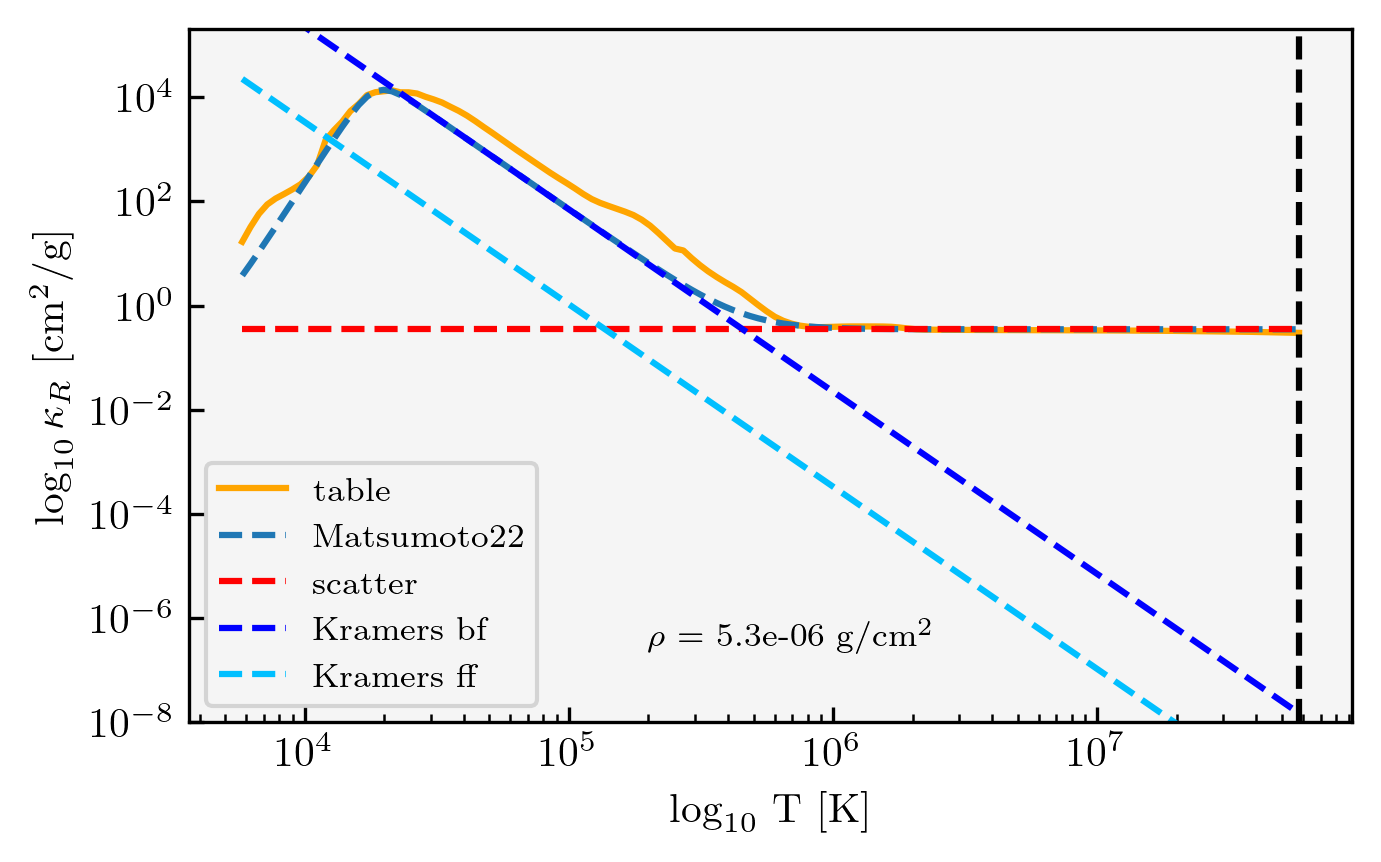

In [10]:
"""Rosseland"""
plt.plot(temp_table,ross_selected[idx], label = 'table', c ='orange')
plt.plot(temp_table,kappa_matsu[idx], linestyle = 'dashed', label = 'Matsumoto22')
plt.plot(temp_table,theory_scattering[idx], linestyle = 'dashed', c = 'r', label = 'scatter')
plt.plot(temp_table,kappa_kramer_boundfree[idx], linestyle = 'dashed', c = 'b', label = 'Kramers bf')
plt.plot(temp_table,kappa_kramer_freefree[idx], linestyle = 'dashed', c = 'deepskyblue', label = 'Kramers ff')
plt.xlabel(r'$\log_{10}$ T [K]')
plt.ylabel(r'$\log_{10} \kappa_R$ [cm$^2$/g]')
plt.text(2e5, 3e-7, r'$\rho$ = %.1e g/cm$^2$' %rho_test[idx], fontsize = 8)
plt.axvline(temp_table[-1], linestyle = '--', c = 'k')
#plt.xlim(3e3,1e8)
plt.loglog()
plt.ylim(1e-8,2e5)
plt.legend(fontsize = 8)
plt.savefig('Figs/Opacities/rosseland.png')
plt.show()

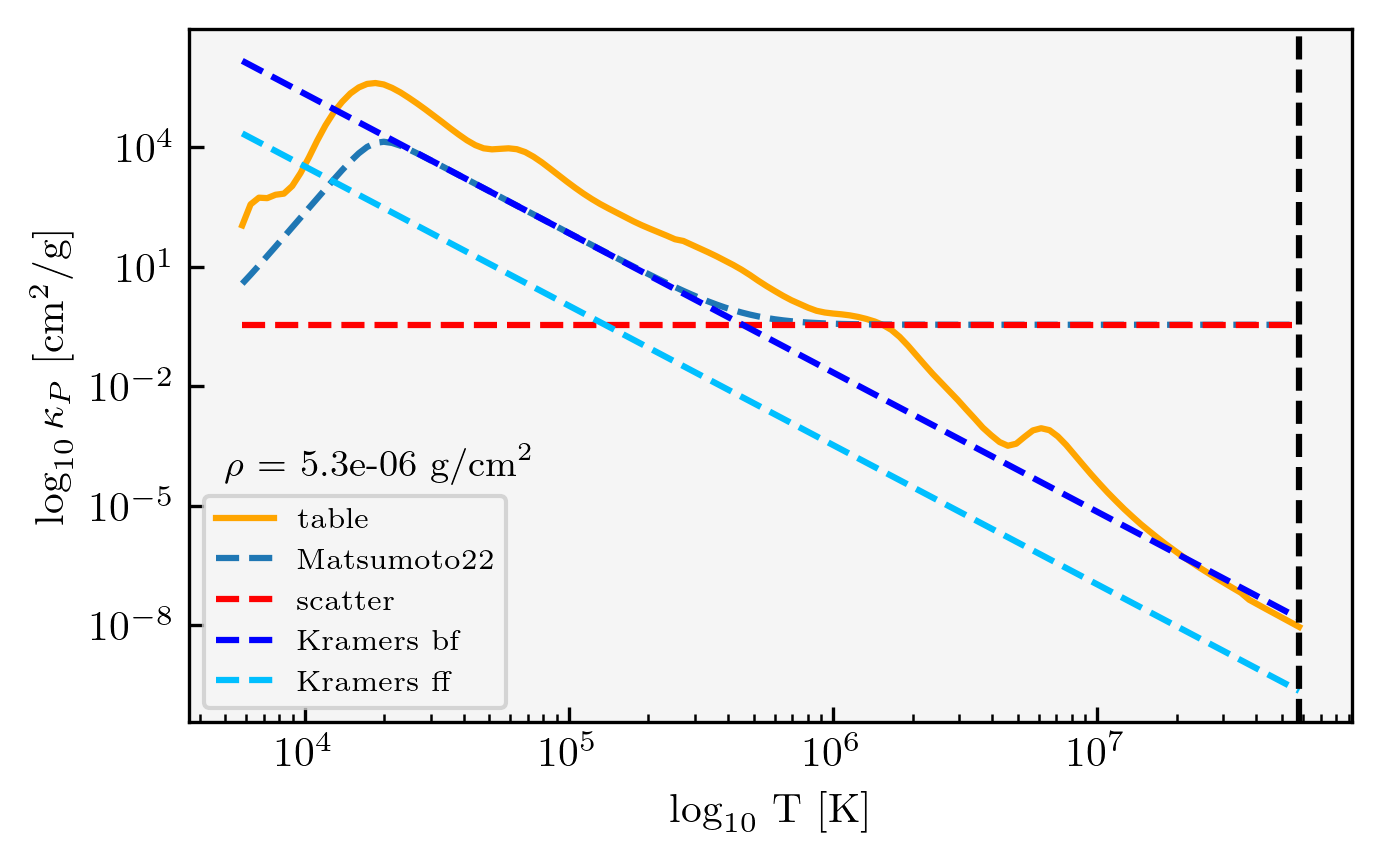

In [11]:
"""Absorption"""
plt.plot(temp_table,planck_selected[idx], label = 'table', c = 'orange')
plt.plot(temp_table,kappa_matsu[idx], linestyle = 'dashed', label = 'Matsumoto22')
plt.plot(temp_table,theory_scattering[idx], linestyle = 'dashed', c= 'r', label = 'scatter')
plt.plot(temp_table,kappa_kramer_boundfree[idx], linestyle = 'dashed', c = 'b', label = 'Kramers bf')
plt.plot(temp_table,kappa_kramer_freefree[idx], linestyle = 'dashed', c = 'deepskyblue', label = 'Kramers ff')
plt.xlabel(r'$\log_{10}$ T [K]')
plt.ylabel(r'$\log_{10} \kappa_P$ [cm$^2$/g]')
plt.text(5e3, 6e-5, r'$\rho$ = %.1e g/cm$^2$' %rho_test[idx], fontsize = 9)
plt.axvline(temp_table[-1], linestyle = '--', c = 'k')
#plt.xlim(3e3,1e8)
plt.loglog()
#plt.ylim(1e-8,1e2)
plt.legend( fontsize = 7)
plt.savefig('Figs/Opacities/planck.png')
plt.show()

In [12]:
kappa_kramer_freefree = np.array(kappa_kramer_freefree)
kappa_kramer_boundfree = np.array(kappa_kramer_boundfree)
theory_scattering = np.array(theory_scattering)

In [13]:
theory_photo = kappa_kramer_boundfree + theory_scattering
theory_therm = np.sqrt(kappa_kramer_boundfree * (kappa_kramer_boundfree + theory_scattering))

In [14]:
planck_selected = np.array(planck_selected)
scatter_selected = np.array(scatter_selected)

In [15]:
photo_selected = planck_selected + scatter_selected
therm_selected = np.sqrt(planck_selected * (planck_selected + scatter_selected))

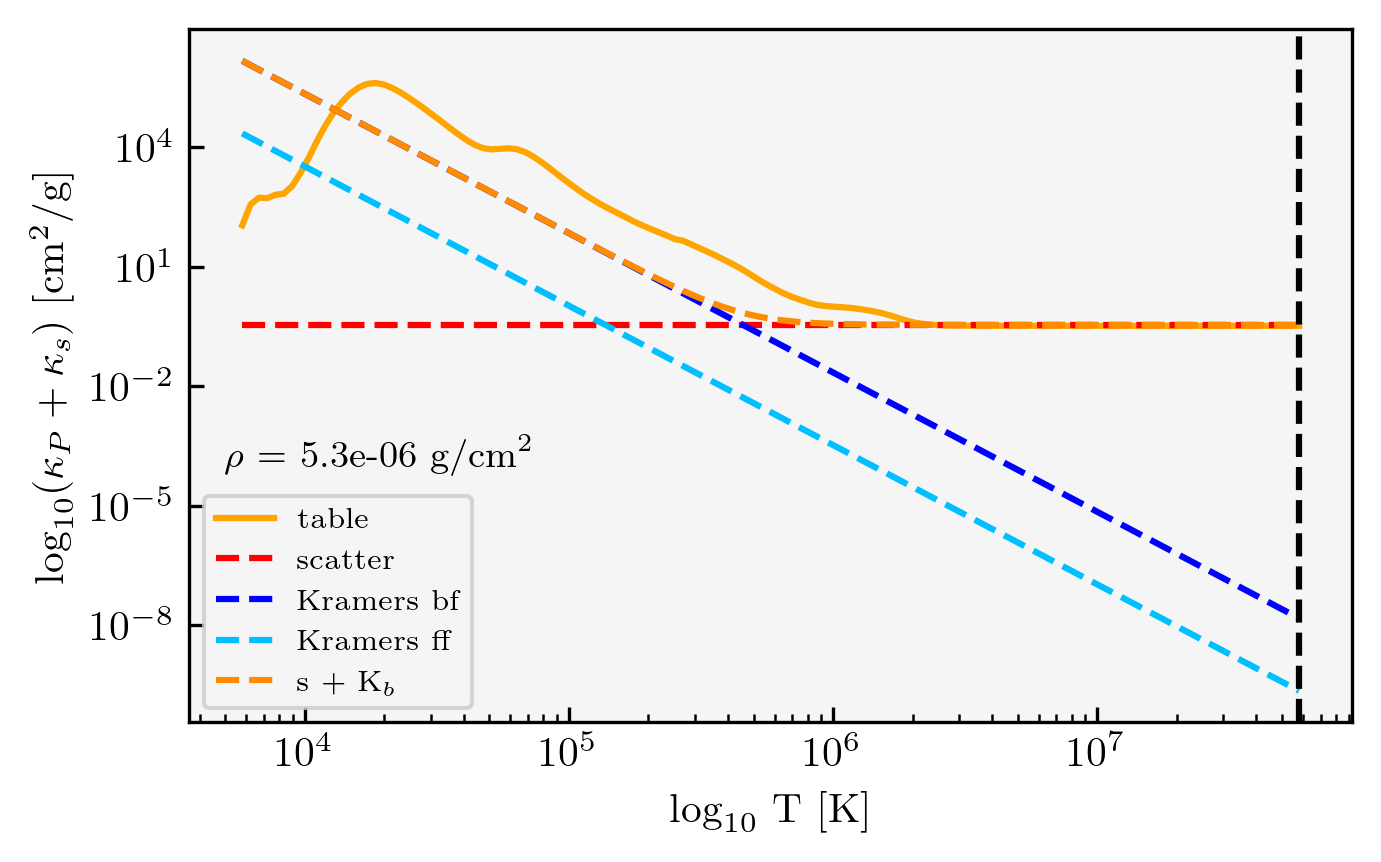

In [26]:
"""Photosphere"""
plt.plot(temp_table, photo_selected[idx], label = 'table', c = 'orange')
plt.plot(temp_table, theory_scattering[idx],  linestyle = 'dashed', label = 'scatter', c = 'r')
plt.plot(temp_table, kappa_kramer_boundfree[idx], linestyle = 'dashed', c = 'b', label = 'Kramers bf')
plt.plot(temp_table, kappa_kramer_freefree[idx], linestyle = 'dashed', c = 'deepskyblue', label = 'Kramers ff')
plt.plot(temp_table, theory_photo[idx], linestyle = 'dashed', label = r's + K$_b$', c = 'darkorange')
plt.xlabel(r'$\log_{10}$ T [K]')
plt.ylabel(r'$\log_{10} (\kappa_P+\kappa_s)$ [cm$^2$/g]')
plt.text(5e3, 1e-4, r'$\rho$ = %.1e g/cm$^2$' %rho_test[idx], fontsize = 9)
plt.axvline(temp_table[-1], linestyle = '--', c = 'k')
#plt.xlim(3e3,1e8)
plt.loglog()
#plt.ylim(1e-8,1e2)
plt.legend(fontsize = 7)
plt.savefig('Figs/Opacities/kappalaws_photo.png')
plt.show()

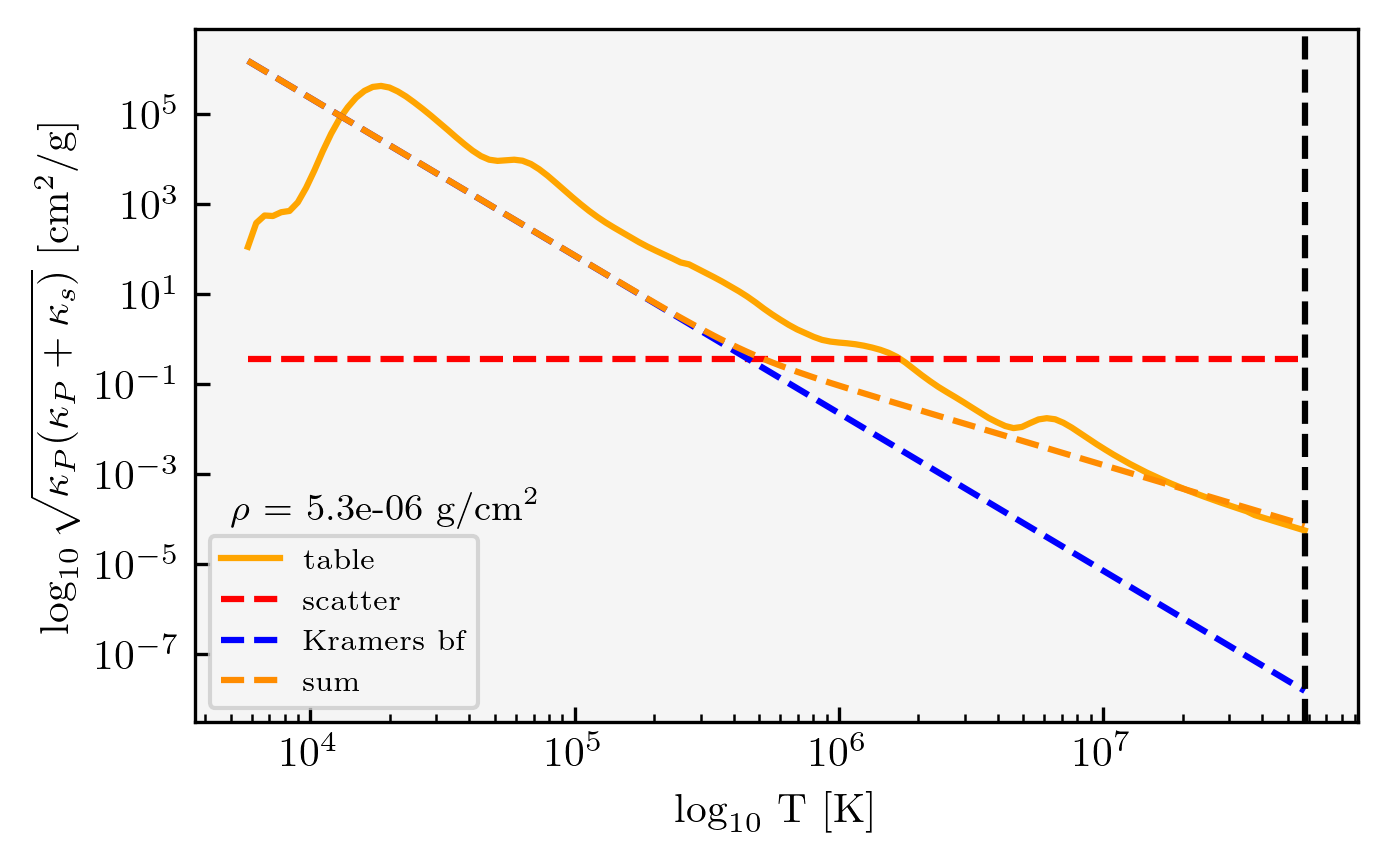

In [25]:
"""Therm radius"""
plt.plot(temp_table,therm_selected[idx], label = 'table', c = 'orange')
#plt.plot(temp_table,kappa_matsu[idx], linestyle = 'dashed', label = 'Matsumoto22')
plt.plot(temp_table,theory_scattering[idx],  linestyle = 'dashed', label = 'scatter', c = 'r')
plt.plot(temp_table,kappa_kramer_boundfree[idx], linestyle = 'dashed', c = 'b', label = 'Kramers bf')
#plt.plot(temp_table,kappa_kramer_freefree[idx], linestyle = 'dashed', c = 'deepskyblue', label = 'Kramers ff')
plt.plot(temp_table,theory_therm[idx], linestyle = 'dashed', label = 'sum', c = 'darkorange')
plt.xlabel(r'$\log_{10}$ T [K]')
plt.ylabel(r'$\log_{10} \sqrt{\kappa_P(\kappa_P+\kappa_s)}$ [cm$^2$/g]')
plt.text(5e3, 1e-4, r'$\rho$ = %.1e g/cm$^2$' %rho_test[idx], fontsize = 9)
plt.axvline(temp_table[-1], linestyle = '--', c = 'k')
#plt.xlim(3e3,1e8)
plt.loglog()
#plt.ylim(1e-8,1e2)
plt.legend(fontsize = 7)
plt.savefig('Figs/Opacities/kappalaws_therm.png')
plt.show()

In [18]:
""" Using our simulation. """
# X = np.load( str(m) + '/'  + fix + '/CMx_' + fix + '.npy')
# Y = np.load( str(m) + '/'  + fix + '/CMy_' + fix + '.npy')
# Z = np.load( str(m) + '/'  + fix + '/CMz_' + fix + '.npy')
# Mass = np.load( str(m) + '/'  + fix + '/Mass_' + fix + '.npy')
# T = np.load( str(m) + '/'  + fix + '/T_' + fix + '.npy')
# Den = np.load( str(m) + '/'  + fix + '/Den_' + fix + '.npy')

# Den *= den_converter 
# R, THETA, PHI = cartesian_to_spherical(X,Y,Z)
# R = R.value 
# THETA = THETA.value
# PHI = PHI.value

' Using our simulation. '

In [19]:
# thetas = np.zeros(192)
# phis = np.zeros(192)
# observers = []
# NSIDE = 4
# for i in range(0,192):
#     thetas[i], phis[i] = hp.pix2ang(NSIDE, i)
#     thetas[i] -= np.pi/2 # Enforce theta in -pi to pi
    
#     observers.append( (thetas[i], phis[i]) )

In [20]:
# index = 91
# data_den = rays_den[index]
# data_T =rays_T[index]
# kappa = plot_kappa[index]
# kram = 3.68 * 1e22 * (1 + 0.7389) * data_T**(-3.5) * data_den**2 #Kramers' opacity [cm^2/g]
# scattering = (1+0.7389) * 0.2 * data_den 
# sum =  (kram + scattering) 
# plt.scatter(data_T,kappa, s = 8, c = 'k', label = 'Table')
# plt.scatter(data_T, kram, s = 5, c = 'r', label = 'Kramers')
# plt.scatter(data_T, scattering, s = 2, c = 'b', label = 'Scattering')
# plt.scatter(data_T,sum, s = 1, c = 'orange', label = 'sum')
# plt.legend()
# plt.axvline(x=np.exp(17.87), c = 'k', linestyle = 'dashed')
# plt.xlabel('T [K]')
# plt.ylabel(r'$\kappa\rho$ [1/cm]')
# plt.loglog()
# plt.title(r'R$_{ph}$ in logspace')
# plt.savefig('Final plot/photosphere_comparison_log.png')
# plt.show()